# Sentiment Analysis- NLP-driven Classification of Yelp Reviews for Star Rating Prediction

In this NLP project, I will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews.

I will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

## Importing Libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
%matplotlib inline

## The Data

**Reading the yelp.csv file and set it as a dataframe called yelp.**

In [2]:
yelp = pd.read_csv('yelp.csv')

**Checking the head, info , and describe methods on yelp.**

In [3]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [5]:
yelp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
stars,10000.0,3.7775,1.214636,1.0,3.0,4.0,5.0,5.0
cool,10000.0,0.8768,2.067861,0.0,0.0,0.0,1.0,77.0
useful,10000.0,1.4093,2.336647,0.0,0.0,1.0,2.0,76.0
funny,10000.0,0.7013,1.907942,0.0,0.0,0.0,1.0,57.0


**Creating a new column called "text length" which is the number of words in the text column.**

In [6]:
yelp['text length'] = yelp['text'].apply(len)

In [7]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469


**Finding the longest review.**

In [8]:
yelp['text length'].max()

4997

In [9]:
print(yelp[yelp['text length'] == 4997]['text'].iloc[0])

In our continuing quest to identify cool, locally owned places to eat and/or drink, Caroline and I auditioned Vintage 95 last night. 

Before I go further, understand that whenever I go out for eats or drinks, I have  in  mind a Platonic Ideal of the Bar/Pub/Eatery I most want to frequent. I'm on a constant quest to find that  Ideal expressed in Real Life. 

Vintage 95 isn't quite there, but it's damn close. If I ever give something Five Stars, you'll know it has pegged my Platonic Ideal. Anyway...

The plan last night was for drinks. No plans for food, just Adult Beverages and warm conversation. But it turned into more.

The location in downtown Chandler is terrific for us. The owners have created a very fine visual experience - leather, stone, dark woods, good lighting. And they don't have the music turned up so loud that you CANNOT HAVE A CONVERSATION. This is one of my pet peeves. If I want to stare at people move their mouths while enduring an aural assault, I'll stand on the deck

# Exploratory Data Analysis (EDA)

Let's explore the data.

Plotting the histogram of reviews per each score(stars)

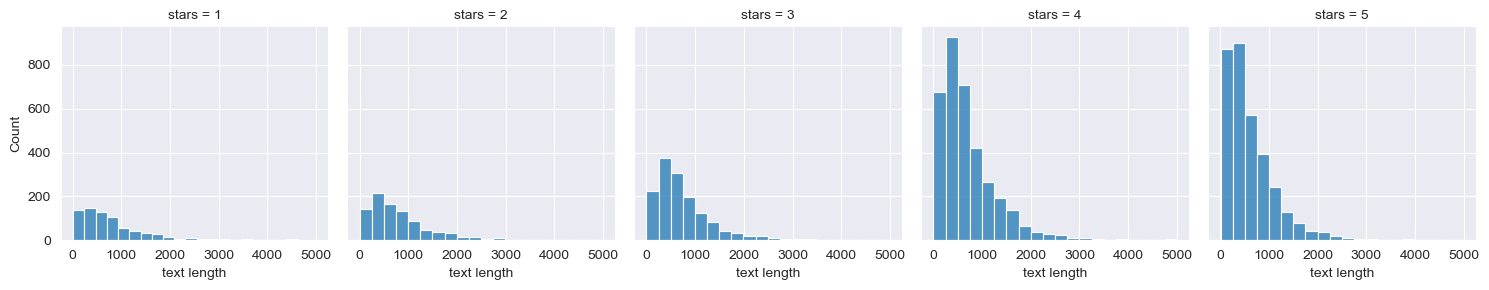

In [14]:
g = sns.FacetGrid(data=yelp, col='stars')
g.map(sns.histplot, 'text length', bins=20)

<Axes: xlabel='stars', ylabel='text length'>

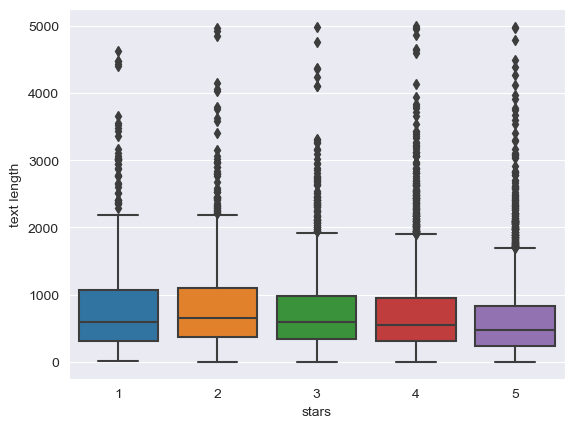

In [16]:
sns.boxplot(data=yelp, x='stars', y='text length')

<Axes: xlabel='stars', ylabel='count'>

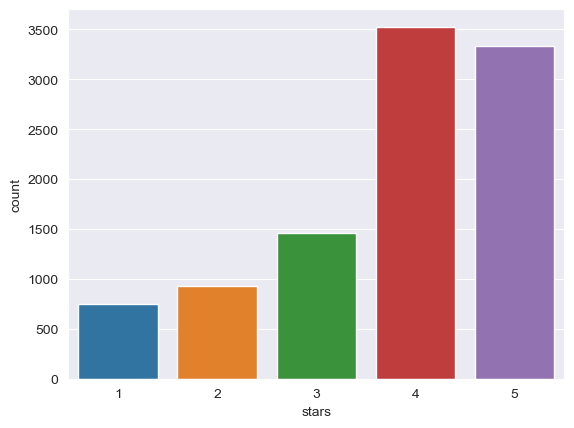

In [17]:
sns.countplot(data=yelp, x='stars')

<Axes: >

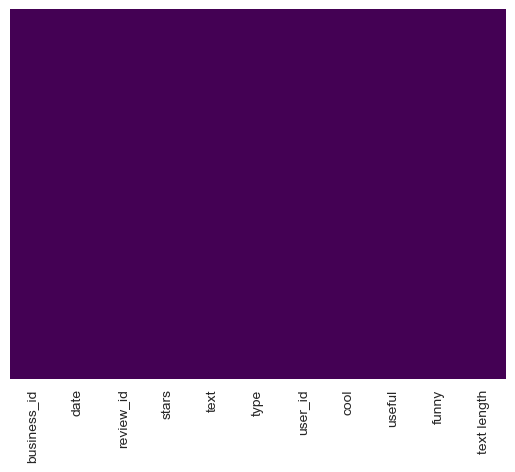

In [22]:
sns.heatmap(data=yelp.isnull(), yticklabels=False, cbar=False, cmap='viridis')

The above figure shows no missing records in this dataset.

In [11]:
yelp.groupby('stars').mean()

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


**Using the corr() method on the above groupby dataframe to produce this corrolation table**

In [12]:
yelp.groupby('stars').mean().corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


**Then using seaborn to create a heatmap based off that .corr() dataframe:**

<Axes: >

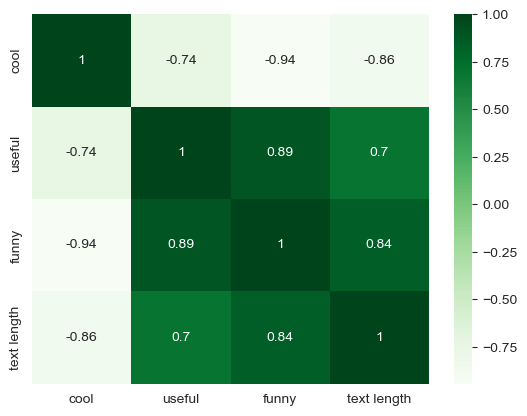

In [13]:
sns.heatmap(data=yelp.groupby('stars').mean().corr(), annot=True, cmap='Greens')

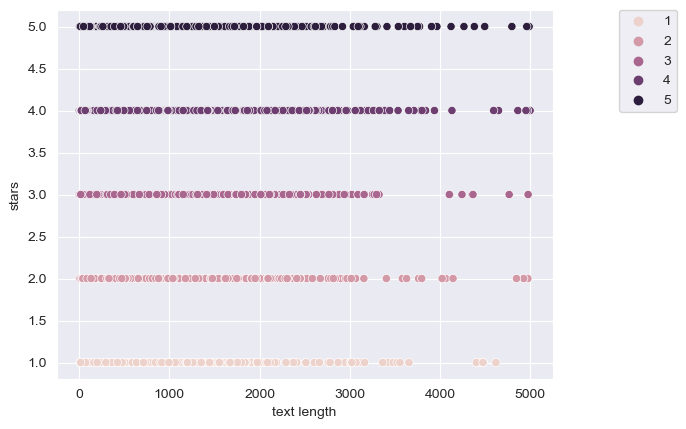

In [14]:
sns.scatterplot(data=yelp, x='text length', y='stars', hue='stars')
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

## NLP Classification Task

In [15]:
yelp.columns

Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny', 'text length'],
      dtype='object')

**In this task, my goal is to remove punctuation and stop words, then return each review as list of words.**

In [16]:
def clean_text(sentence):
    """
    1.Remove Punctuations
    2.Remove Stop Words
    3.Return a List of Words
    """
    no_punc_list = [char for char in list(sentence) if char not in string.punctuation]
    no_punc_str = ''.join(no_punc_list)
    return [word for word in no_punc_str.split() if word.lower() not in stopwords.words('english')]

In [17]:
yelp['text'].head().apply(clean_text)

0    [wife, took, birthday, breakfast, excellent, w...
1    [idea, people, give, bad, reviews, place, goes...
2    [love, gyro, plate, Rice, good, also, dig, can...
3    [Rosie, Dakota, LOVE, Chaparral, Dog, Park, co...
4    [General, Manager, Scott, Petello, good, egg, ...
Name: text, dtype: object

Using CountVectorizer and applying clean_text function as analyzer, I am creating a bag_of_words including messages on rows and vocabularies as culomns.

In [18]:
bag_of_words = CountVectorizer(analyzer=clean_text).fit(yelp['text'])

In [19]:
print(f'Number of unique words: {len(bag_of_words.vocabulary_)}')

Number of unique words: 44012


Understanding how bag_of_words works:

In [20]:
message4 = yelp['text'][3].lower()
message4

"rosie, dakota, and i love chaparral dog park!!! it's very convenient and surrounded by a lot of paths, a desert xeriscape, baseball fields, ballparks, and a lake with ducks.\n\nthe scottsdale park and rec dept. does a wonderful job of keeping the park clean and shaded.  you can find trash cans and poopy-pick up mitts located all over the park and paths.\n\nthe fenced in area is huge to let the dogs run, play, and sniff!"

In [22]:
bow4 = bag_of_words.transform([message4])
print(bow4)
print(bow4.shape)
print(type(bow4))

  (0, 16219)	1
  (0, 16834)	1
  (0, 17001)	1
  (0, 18681)	1
  (0, 19103)	1
  (0, 19639)	1
  (0, 20471)	1
  (0, 21805)	1
  (0, 21834)	1
  (0, 22443)	1
  (0, 22456)	1
  (0, 22841)	1
  (0, 24270)	1
  (0, 24316)	1
  (0, 24393)	1
  (0, 27490)	1
  (0, 28656)	1
  (0, 28824)	1
  (0, 29109)	1
  (0, 29407)	1
  (0, 29686)	1
  (0, 29818)	1
  (0, 29850)	1
  (0, 30985)	1
  (0, 33109)	4
  (0, 33236)	2
  (0, 33949)	1
  (0, 34130)	1
  (0, 35399)	1
  (0, 36558)	1
  (0, 37063)	1
  (0, 37500)	1
  (0, 38362)	1
  (0, 39888)	1
  (0, 41406)	1
  (0, 43549)	1
  (0, 43745)	1
(1, 44012)
<class 'scipy.sparse._csr.csr_matrix'>


In [23]:
print(bag_of_words.get_feature_names_out()[33109])
print(bag_of_words.get_feature_names_out()[33236])

park
paths


**Transforming all of the reviews into a large matrix(Sparse Matrix) similar to bag_of_words in which each row represents a review and each column is a word whose value is the number of occurrences of that particular word in the review.**

In [24]:
transformed_messages = bag_of_words.transform(yelp['text'])

In [25]:
print(f'Shape of Sparse Matrix {transformed_messages.shape}')

Shape of Sparse Matrix (10000, 44012)


In [26]:
print(f'Number of non-zero values: {transformed_messages.nnz}')

Number of non-zero values: 583230


In [28]:
print(f'The number of elements of Sparse matrix: {transformed_messages.shape[0] * transformed_messages.shape[1]}')

The number of elements of Sparse matrix: 440120000


In [29]:
print(f'Density: {transformed_messages.nnz / (transformed_messages.shape[0] * transformed_messages.shape[1]) * 100} %')
print(f'Sparsity : {1 - (transformed_messages.nnz / (transformed_messages.shape[0] * transformed_messages.shape[1]))} %')

Density: 0.1325161319640098 %
Sparsity : 0.9986748386803599 %


**Transforming elements of Sparse Matrix using "tf-idf" transformation which is a common step in NLP tasks.**

tf-idf(t, d) = tf(t, d) * idf(t) while idf(t) = log [ n / df(t) ] + 1

In [30]:
tfidf = TfidfTransformer().fit(transformed_messages)

In [31]:
tfidf4 = tfidf.transform(bow4)
print(tfidf4)

  (0, 43745)	0.20073158943921474
  (0, 43549)	0.08914224521558817
  (0, 41406)	0.14225423351718056
  (0, 39888)	0.1511381511061269
  (0, 38362)	0.19217982435028616
  (0, 37500)	0.1629411463892691
  (0, 37063)	0.14746082060467375
  (0, 36558)	0.0987283690756727
  (0, 35399)	0.19217982435028616
  (0, 34130)	0.20073158943921474
  (0, 33949)	0.11009647786196763
  (0, 33236)	0.3335730710633799
  (0, 33109)	0.43218869264586524
  (0, 30985)	0.19217982435028616
  (0, 29850)	0.06185012215335542
  (0, 29818)	0.07353691192022985
  (0, 29686)	0.10666157816584453
  (0, 29407)	0.09161979663707574
  (0, 29109)	0.15559492357325197
  (0, 28824)	0.1341465110996942
  (0, 28656)	0.09562110700256242
  (0, 27490)	0.08273214509258306
  (0, 24393)	0.07176308518735629
  (0, 24316)	0.15559492357325197
  (0, 24270)	0.17756048536977762
  (0, 22841)	0.1629411463892691
  (0, 22456)	0.11780448052330632
  (0, 22443)	0.10740605243620907
  (0, 21834)	0.11301555555616345
  (0, 21805)	0.16477632490697525
  (0, 20471)	0.1

In [32]:
messages_tfidf = tfidf.transform(transformed_messages)
print(messages_tfidf.shape)

(10000, 44012)


In [33]:
print(tfidf.idf_[bag_of_words.vocabulary_['university']])

8.41868089774846


## Train/CV/Test Split

Let's split our data into train, cv, and test data.

In [34]:
X_train, X_, y_train, y_ = train_test_split(yelp['text'], yelp['stars'], test_size=0.3, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)

In [35]:
print(f'X_train size: {X_train.shape}')
print(f'y_train size: {y_train.shape}')
print(f'X_cv size: {X_cv.shape}')
print(f'y_cv size: {y_cv.shape}')
print(f'X_test size: {X_test.shape}')
print(f'y_test size: {y_test.shape}')

X_train size: (7000,)
y_train size: (7000,)
X_cv size: (1500,)
y_cv size: (1500,)
X_test size: (1500,)
y_test size: (1500,)


## Training a Model

Time to train a model!

**For the classification task, I am using Multinomial Naive Bayes algorithm. Then I repeat that using Support Vector Machine to compare the result.**

In [36]:
spam_classifier = MultinomialNB()

Using the Pipeline
Time to use the pipeline!

In [37]:
pipeline = Pipeline([
    ('Preprocessing', CountVectorizer(analyzer=clean_text)),
    ('TF-IDF', TfidfTransformer()),
    ('Review Stars Classifier', MultinomialNB()),]
)

In [38]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 CountVectorizer(analyzer=<function clean_text at 0x15db29c60>)),
                ('TF-IDF', TfidfTransformer()),
                ('Review Stars Classifier', MultinomialNB())])

## Predictions and Evaluations

Time to see how my model did!

In [39]:
pred_cv = pipeline.predict(X_cv)

In [40]:
print(confusion_matrix(y_cv, pred_cv))
print('\n')
print(classification_report(y_cv, pred_cv))

[[  0   0   0 104  14]
 [  0   0   0 142  13]
 [  0   0   0 203   8]
 [  0   0   0 457  63]
 [  0   0   0 335 161]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       118
           2       0.00      0.00      0.00       155
           3       0.00      0.00      0.00       211
           4       0.37      0.88      0.52       520
           5       0.62      0.32      0.43       496

    accuracy                           0.41      1500
   macro avg       0.20      0.24      0.19      1500
weighted avg       0.33      0.41      0.32      1500



**Although in most of cases Tf-Idf helps the prediction effectively, here it looks like Tf-Idf actually made things worse!**

Let's investigate if we can define a pipleline and include only Countvectorizer and Naive Bayes Classifier.

In [41]:
pipeline_new = Pipeline([
    ('Preprocessing', CountVectorizer(analyzer=clean_text)),
    ('Review Stars Classifier', MultinomialNB()),]
)

In [42]:
pipeline_new.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 CountVectorizer(analyzer=<function clean_text at 0x15db29c60>)),
                ('Review Stars Classifier', MultinomialNB())])

In [43]:
pred_cv_new = pipeline_new.predict(X_cv)

In [44]:
print(confusion_matrix(y_cv, pred_cv_new))
print('\n')
print(classification_report(y_cv, pred_cv_new))

[[ 25   7   6  57  23]
 [  7   7  15 110  16]
 [  2   2  13 170  24]
 [  3   1   2 395 119]
 [  0   0   0 240 256]]


              precision    recall  f1-score   support

           1       0.68      0.21      0.32       118
           2       0.41      0.05      0.08       155
           3       0.36      0.06      0.11       211
           4       0.41      0.76      0.53       520
           5       0.58      0.52      0.55       496

    accuracy                           0.46      1500
   macro avg       0.49      0.32      0.32      1500
weighted avg       0.48      0.46      0.41      1500



Seems Everything got better! Still can work on that.

In [45]:
pred_test = pipeline_new.predict(X_test)

In [46]:
print(confusion_matrix(y_test, pred_test))
print('\n')
print(classification_report(y_test, pred_test))

[[ 19   9   9  43  20]
 [  1   8  12  77  12]
 [  0   2  11 192  26]
 [  1   0   3 439 124]
 [  1   1   0 248 242]]


              precision    recall  f1-score   support

           1       0.86      0.19      0.31       100
           2       0.40      0.07      0.12       110
           3       0.31      0.05      0.08       231
           4       0.44      0.77      0.56       567
           5       0.57      0.49      0.53       492

    accuracy                           0.48      1500
   macro avg       0.52      0.32      0.32      1500
weighted avg       0.49      0.48      0.43      1500



**Now, I want to repeat the classification task using SVM.**

In [47]:
pipeline_new_svc= Pipeline([
    ('Preprocessing', CountVectorizer(analyzer=clean_text)),
    ('Review Stars Classifier', SVC()),]
)

In [48]:
pipeline_new_svc.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 CountVectorizer(analyzer=<function clean_text at 0x15db29c60>)),
                ('Review Stars Classifier', SVC())])

In [49]:
pred_cv_svc = pipeline_new_svc.predict(X_cv)

In [50]:
print(confusion_matrix(y_cv, pred_cv_svc))
print('\n')
print(classification_report(y_cv, pred_cv_svc))

[[ 18   6   3  53  38]
 [  5  19   8  91  32]
 [  2   4  11 153  41]
 [  1   0   2 344 173]
 [  1   0   0 162 333]]


              precision    recall  f1-score   support

           1       0.67      0.15      0.25       118
           2       0.66      0.12      0.21       155
           3       0.46      0.05      0.09       211
           4       0.43      0.66      0.52       520
           5       0.54      0.67      0.60       496

    accuracy                           0.48      1500
   macro avg       0.55      0.33      0.33      1500
weighted avg       0.51      0.48      0.43      1500



**Therefore, the results are almost the same for Naive Bayes and Support Vector Machine algorithms.
For sure the result can improve if more efforts are done on the data, but here my objective was to show simple and common steps of NLP tasks.**